In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as skl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imageio import imread

import sys

sys.path.insert(0, "../")

import linear_regression
import utils
import stat_tools
import crossvalidation
import bootstrap
from FrankeFunction import FrankeFunction

utils.plot_settings()  # LaTeX fonts in Plots!

FIGURESIZE= np.array([4,3]) # Good default figure size for tex documents

In [2]:
n=200 # Try 200, and try 1000
noise_scale=0.2 # Try 0, and try 0.2
max_degree=15 # Don't increase without increasing number of points
n_bootstraps=100
k_folds=5
n_lambdas=30
do_boot=True
do_subset=True


np.random.seed(2018)
# n = 500
# noise_scale = 0.2
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
# max_degree = 15
# n_lambdas = 30
# n_bootstraps = 100
# k_folds = 5
lambdas = np.logspace(-6, 0, n_lambdas)
subset_lambdas = np.logspace(-6,0,7)

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x, y, z, test_size=0.2)

#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept

#   Centering the response
z_train_intercept = np.mean(z_train)
z_train = z_train - z_train_intercept
z_test = z_test - z_train_intercept

########### Setup of problem is completed above.

# Quantities of interest: note the indexing, element 0 is polynomial degree 1
mse_ols_test = np.zeros(max_degree)
mse_ols_train = np.zeros(max_degree)
ols_cv_mse = np.zeros(max_degree)

ols_boot_mse = np.zeros(max_degree)
ols_boot_bias = np.zeros(max_degree)
ols_boot_variance = np.zeros(max_degree)

best_ridge_lambda = np.zeros(max_degree)
best_ridge_mse = np.zeros(max_degree)
ridge_best_lambda_boot_mse = np.zeros(max_degree)
ridge_best_lambda_boot_bias = np.zeros(max_degree)
ridge_best_lambda_boot_variance = np.zeros(max_degree)

best_lasso_lambda = np.zeros(max_degree)
best_lasso_mse = np.zeros(max_degree)
lasso_best_lambda_boot_mse = np.zeros(max_degree)
lasso_best_lambda_boot_bias = np.zeros(max_degree)
lasso_best_lambda_boot_variance = np.zeros(max_degree)

ridge_lamb_deg_mse = np.zeros((max_degree, n_lambdas))
lasso_lamb_deg_mse = np.zeros((max_degree, n_lambdas))

ridge_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
ridge_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_mse = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_bias = np.zeros((max_degree, len(subset_lambdas)))
lasso_subset_lambda_boot_variance = np.zeros((max_degree, len(subset_lambdas)))

# Actual computations
for degree_index in range(max_degree):
    degree = degree_index + 1 # Little sense in doing stuff for 0 degrees.
    X = linear_regression.design_matrix_2D(x, y, degree)
    X_train = linear_regression.design_matrix_2D(x_train, y_train, degree)
    X_test = linear_regression.design_matrix_2D(x_test, y_test, degree)
    # Scaling and feeding to CV.
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_scaled = X_scaled[:,1:]
    #    X_scaled[:,0] = 1 # Maybe not for ridge+lasso. Don't want to penalize constants...

    # Scaling and feeding to bootstrap and OLS
    scaler_boot = StandardScaler()
    scaler_boot.fit(X_train)
    X_train_scaled = scaler_boot.transform(X_train)
    X_test_scaled = scaler_boot.transform(X_test)
    X_train_scaled = X_train_scaled[:,1:]
    X_test_scaled = X_test_scaled[:,1:]
    #    X_train_scaled[:,0] = 1 #maybe not for ridge+lasso
    #    X_test_scaled[:,0] = 1 #maybe not for ridge+lasso

    # OLS, get MSE for test and train set.

    betas = linear_regression.OLS_SVD_2D(X_train_scaled, z_train)
    z_test_model = X_test_scaled @ betas
    z_train_model = X_train_scaled @ betas
    mse_ols_train[degree_index] = stat_tools.MSE(z_train, z_train_model)
    mse_ols_test[degree_index] = stat_tools.MSE(z_test, z_test_model)

    # CV, find best lambdas and get mse vs lambda for given degree. Also, gets
    # ols_CV_MSE

    lasso_cv_mse, ridge_cv_mse, ols_cv_mse_deg = crossvalidation.k_fold_cv_all(
        X_scaled, z, n_lambdas, lambdas, k_folds
    )
    best_lasso_lambda[degree_index] = lambdas[np.argmin(lasso_cv_mse)]
    best_ridge_lambda[degree_index] = lambdas[np.argmin(ridge_cv_mse)]
    best_lasso_mse[degree_index] = np.min(lasso_cv_mse)
    best_ridge_mse[degree_index] = np.min(ridge_cv_mse)
    lasso_lamb_deg_mse[degree_index] = lasso_cv_mse
    ridge_lamb_deg_mse[degree_index] = ridge_cv_mse
    ols_cv_mse[degree_index] = ols_cv_mse_deg

    if do_boot:
        # All regression bootstraps at once
        lamb_ridge = best_ridge_lambda[degree_index]
        lamb_lasso = best_lasso_lambda[degree_index]

        (
            ridge_mse,
            ridge_bias,
            ridge_variance,
            lasso_mse,
            lasso_bias,
            lasso_variance,
            ols_mse,
            ols_bias,
            ols_variance,
        ) = bootstrap.bootstrap_all(
            X_train_scaled, X_test_scaled, z_train, z_test, n_bootstraps, lamb_lasso, lamb_ridge
        )

        (
            ridge_best_lambda_boot_mse[degree_index],
            ridge_best_lambda_boot_bias[degree_index],
            ridge_best_lambda_boot_variance[degree_index],
        ) = (ridge_mse, ridge_bias, ridge_variance)

        (
            lasso_best_lambda_boot_mse[degree_index],
            lasso_best_lambda_boot_bias[degree_index],
            lasso_best_lambda_boot_variance[degree_index],
        ) = (lasso_mse, lasso_bias, lasso_variance)

        ols_boot_mse[degree_index], ols_boot_bias[degree_index], ols_boot_variance[degree_index] = (
            ols_mse,
            ols_bias,
            ols_variance,
        )

    if do_subset:
        # Bootstrapping for a selection of lambdas for ridge and lasso
        subset_lambda_index = 0
        for lamb in subset_lambdas:

            (
                ridge_mse,
                ridge_bias,
                ridge_variance,
                lasso_mse,
                lasso_bias,
                lasso_variance,
            ) = bootstrap.bootstrap_ridge_lasso(
                X_train_scaled,
                X_test_scaled,
                z_train,
                z_test,
                n_bootstraps,
                lamb_lasso,
                lamb_ridge,
            )

            (
                ridge_subset_lambda_boot_mse[degree_index, subset_lambda_index],
                ridge_subset_lambda_boot_bias[degree_index, subset_lambda_index],
                ridge_subset_lambda_boot_variance[degree_index, subset_lambda_index],
            ) = (ridge_mse, ridge_bias, ridge_variance)

            (
                lasso_subset_lambda_boot_mse[degree_index, subset_lambda_index],
                lasso_subset_lambda_boot_bias[degree_index, subset_lambda_index],
                lasso_subset_lambda_boot_variance[degree_index, subset_lambda_index],
            ) = (lasso_mse, lasso_bias, lasso_variance)

            subset_lambda_index += 1


/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1405451011020205, tolerance: 0.0019729954913708042
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3282757687123192, tolerance: 0.0020488711215031806
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.131418932411942, tolerance: 0.001980621523014039
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4371973594344292, tolerance: 0.001782065479101682
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9018388445055758, tolerance: 0.0023607463066714343
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8698545086879745, tolerance: 0.001636814318883016
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5378101209980373, tolerance: 0.0022959826107468197
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8412748658344316, tolerance: 0.001849295788415774
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6913258563290126, tolerance: 0.001738002739281751
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6390665236876238, tolerance: 0.0016732361396751955
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2384053746444157, tolerance: 0.0020465111018056724
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9520886605293151, tolerance: 0.0014605665426729443
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3707386564656403, tolerance: 0.001676299654546703
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.483681989211183, tolerance: 0.002173114066747014
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7562856790822443, tolerance: 0.0017389045260166854
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7627651413026064, tolerance: 0.0018184374713358315
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7946639104553586, tolerance: 0.0024231106635916734
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7438857958267149, tolerance: 0.0016976337846040547
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7706158042402076, tolerance: 0.0016725147448179792
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8734577255786578, tolerance: 0.0018526922269701338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3000991591883664, tolerance: 0.002074476999874658
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4335379448768162, tolerance: 0.001922615297848928
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0486458889316936, tolerance: 0.001985956884033559
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2198442129740883, tolerance: 0.001932860167748541
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05618769414818381, tolerance: 0.0022078353311377314
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06178045737655591, tolerance: 0.001527142612744075
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016454082974109774, tolerance: 0.001743465091082226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09351262628715684, tolerance: 0.0017962908564365316
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05259643849142037, tolerance: 0.0019478192012260334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015160950446785115, tolerance: 0.001782597660632205
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.049726858663310836, tolerance: 0.0015299774534002183
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003224708625981343, tolerance: 0.0022475411366931573
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012271747710101089, tolerance: 0.0015629007808370165
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_d

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.029321580910421474, tolerance: 0.0021447616186239904
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024541192676498014, tolerance: 0.001661520344865101
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003549600799399144, tolerance: 0.0016303053664511505
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09458093943381574, tolerance: 0.0016662688501769226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005063471245858153, tolerance: 0.001957579256328785
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1053744632576592, tolerance: 0.0019337586718753557
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06058229223792111, tolerance: 0.0020343078181832403
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026384979485142956, tolerance: 0.002075781683976863
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025235727908823335, tolerance: 0.0018377741129104862
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08450289898167096, tolerance: 0.0016311529273326428
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004197821820143055, tolerance: 0.001952997547874856
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009288389445647027, tolerance: 0.0018011471739206575
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008223264680850662, tolerance: 0.002026408078386658
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006344878186272496, tolerance: 0.0018575975538087858
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011063321708322249, tolerance: 0.0014725074778032831
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_de

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015034221485616506, tolerance: 0.0019422960490690672
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004764917902489785, tolerance: 0.001946188090639916
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8822228382320865, tolerance: 0.0016856490625917473
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.741216524530225, tolerance: 0.0019498392010021284
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9965912134714485, tolerance: 0.0012451307260003524
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.132801063803596, tolerance: 0.001592844788336627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9557700694309057, tolerance: 0.0019172962417184792
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.587208448183511, tolerance: 0.001588096423962128
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.09004056678965, tolerance: 0.0021161006313494012
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.997441703186657, tolerance: 0.001995947454773172
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5577241687651466, tolerance: 0.0016580816342408075
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9128705644077306, tolerance: 0.0021180531380070888
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8571314743462084, tolerance: 0.0020667698375530547
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0596497038810493, tolerance: 0.0019381277382877515
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6498318223476502, tolerance: 0.0017159474321376924
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8305518036937176, tolerance: 0.001758656214280901
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6823084580038623, tolerance: 0.0017561366725840322
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4213887362118607, tolerance: 0.001782077015290411
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4800635286854185, tolerance: 0.001818431465754852
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.001646992527757, tolerance: 0.0017794692980667734
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.559555615052297, tolerance: 0.001925243493054095
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8808245326402906, tolerance: 0.002185192549333857
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.088014588599302, tolerance: 0.0018353388551705656
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4110942125010624, tolerance: 0.0016201749006986416
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7571388994874013, tolerance: 0.0016968014247846685
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.036726510577826, tolerance: 0.001997924464053773
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2480861041114504, tolerance: 0.0016653739733744114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.061576997312428, tolerance: 0.0014223561221029055
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.944776660926678, tolerance: 0.001612648887229464
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.563403878196762, tolerance: 0.001781028377143011
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7152731867819604, tolerance: 0.0015876279433529284
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4912124938099494, tolerance: 0.001971536858379144
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.085763393081245, tolerance: 0.0017180539077243308
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9054237391217868, tolerance: 0.0018246645510643362
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4952113755780294, tolerance: 0.0018912649585858892
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5148219282800373, tolerance: 0.0018203027707496926
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.272226926030262, tolerance: 0.0018709714322305666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3903232835702464, tolerance: 0.001597489852666935
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.183048647731765, tolerance: 0.0013472617464646967
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9204920454263434, tolerance: 0.0018960247343266085
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.981747043507482, tolerance: 0.001876583391251098
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9875900838918104, tolerance: 0.001990322100329355
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12212968007896396, tolerance: 0.002041880791424754
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04730364850409163, tolerance: 0.001926055427752953
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.048588319622347775, tolerance: 0.0018960247343266085
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6440770799309083, tolerance: 0.0020974724313242705
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.913721192069667, tolerance: 0.0018680724196458685
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4876359636613232, tolerance: 0.002208586464879225
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6457781069933302, tolerance: 0.0015048664869695368
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8589801904811756, tolerance: 0.0019793199196095237
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1597190719790085, tolerance: 0.0017633669051690603
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.222297664936672, tolerance: 0.00269373149870718
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6392552688047521, tolerance: 0.0015578825372230634
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2281367108369365, tolerance: 0.0019200325853607958
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.370340431141813, tolerance: 0.0016689278095261997
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7808411276722758, tolerance: 0.0021424286364467152
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0942042559315923, tolerance: 0.00179034905327107
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8531931561812405, tolerance: 0.0016610806445239918
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.23096840831695, tolerance: 0.0019294137983728774
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8448683492457219, tolerance: 0.0016522683021312147
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0804095007434182, tolerance: 0.0019425836624962565
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.931649518927761, tolerance: 0.002123311791699579
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2594533043534533, tolerance: 0.0022302307527534036
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1296262593532598, tolerance: 0.0016360834566442868
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.284320477233071, tolerance: 0.0019602191114557947
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2189538859321396, tolerance: 0.001869192723993362
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.250679602748783, tolerance: 0.001803355190040976
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.329032048356774, tolerance: 0.0018617295363482769
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.154642746996394, tolerance: 0.001568448910406284
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0163196726073243, tolerance: 0.0016949736398212897
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6842400948366225, tolerance: 0.0017505506816096641
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7718405561764525, tolerance: 0.0022815977171611796
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.710432072137987, tolerance: 0.0017577898710501927
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.819772996519868, tolerance: 0.001666628550577928
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.196551137097819, tolerance: 0.002183391671464628
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.257495135637373, tolerance: 0.0019089778318827585
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.072309901191641, tolerance: 0.0018402347780318174
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.117303938584164, tolerance: 0.001820488641818185
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8623512851927888, tolerance: 0.0017867902797632
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2394466193248896, tolerance: 0.001786337339623175
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0103480542492553, tolerance: 0.0019441423870126962
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6072047587412426, tolerance: 0.001799929249803444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.258170809259025, tolerance: 0.0017220320024841232
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.531557937731609, tolerance: 0.0017591989403082705
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.38069025607686, tolerance: 0.0020180222795971752
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.338477497177813, tolerance: 0.0019800659838137245
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4867956835454421, tolerance: 0.0016437472356299445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.250253841832767, tolerance: 0.0016812310815647047
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3563132755414813, tolerance: 0.0017279863448738451
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1521562626652235, tolerance: 0.0018013304912393336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3996053592708777, tolerance: 0.0017862099808560624
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.827218042166206, tolerance: 0.001819040193480528
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8937635546856924, tolerance: 0.0019556920034547727
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2838513083344774, tolerance: 0.0016404327397553876
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.751031436770507, tolerance: 0.0017677758580899245
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3404346709598642, tolerance: 0.0017495087870069185
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.818847871458413, tolerance: 0.001713310089446226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1556581988447854, tolerance: 0.001618410683626376
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.16379034743896, tolerance: 0.0019607893890125645
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7681388665416264, tolerance: 0.0018364171062989273
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.541506134242314, tolerance: 0.0017085167052635591
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.142234527182864, tolerance: 0.0021335362061570048
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.832145843047782, tolerance: 0.0021335362061570048
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.59581346912433, tolerance: 0.0019508336015216828
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.416302054499436, tolerance: 0.002101562825843595
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010200468777134652, tolerance: 0.0018364171062989273
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055004631746014, tolerance: 0.0021335362061570048
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002252802161655687, tolerance: 0.0019508336015216828
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_des

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4848244215687343, tolerance: 0.0020717257226221435
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4946566171417945, tolerance: 0.0016449171710284482
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9600897257099898, tolerance: 0.001401356244579943
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0431776200485197, tolerance: 0.0018749756921592707
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6731532160712475, tolerance: 0.002117695491764109
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0734569932414844, tolerance: 0.001869672942022107
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5989581552628858, tolerance: 0.0019203746768483286
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2889050272724805, tolerance: 0.00205081597871813
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4263546381473824, tolerance: 0.0019628086364030313
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8211496242309093, tolerance: 0.0021552481819290263
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1627898880415557, tolerance: 0.001935330820325546
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4801019119807062, tolerance: 0.0019356366188920103
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4614895136945183, tolerance: 0.002148033702320039
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6014134681285803, tolerance: 0.001931536928148102
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.368855316750642, tolerance: 0.001861760943272816
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.416207230083319, tolerance: 0.0018992435615019859
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.238589558189001, tolerance: 0.0019881811593323484
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1320698156349818, tolerance: 0.001498795512714583
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1877824453478019, tolerance: 0.001753026911341842
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7119054532221776, tolerance: 0.0019284829671060027
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8095178110056556, tolerance: 0.0016049259053609191
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1868403766608082, tolerance: 0.0019530240261490775
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4780773979141069, tolerance: 0.0019220075037705252
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0047361242850394, tolerance: 0.0018033282619169264
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9104228952892566, tolerance: 0.0015387150598738133
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3583409940946696, tolerance: 0.0017145890893510629
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2561269677652014, tolerance: 0.0020714431726333946
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4298218646108374, tolerance: 0.001727674178802556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5090900224233641, tolerance: 0.0018729467278734788
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9347252238947978, tolerance: 0.002082147787070996
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1026752303116818, tolerance: 0.002058416814531315
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7717308500847664, tolerance: 0.0019704141141012915
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.373276573555929, tolerance: 0.0016861026241386612
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8243372432161684, tolerance: 0.001793930646983423
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.123574686220587, tolerance: 0.0014687546982343736
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9143959925490943, tolerance: 0.0018251870612657137
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7894885809076717, tolerance: 0.002102461749919391
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8638043961814561, tolerance: 0.00155044852945524
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7709135125647442, tolerance: 0.0019887835721161657
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8654238475902059, tolerance: 0.0016801309293572391
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7947613962468352, tolerance: 0.0019504694427483593
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6935218090292956, tolerance: 0.0018151226655979253
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4726931657844342, tolerance: 0.002017385673659328
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9474300604327275, tolerance: 0.0017899531050213932
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0565354027602747, tolerance: 0.0018739015341667482
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.511624865429737, tolerance: 0.002069979437194905
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2030546630306889, tolerance: 0.001756381479017589
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5411912468989983, tolerance: 0.002218322080108211
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.28637841229316, tolerance: 0.002096503602133576
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7242361299032267, tolerance: 0.001663330002130016
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8436585139375836, tolerance: 0.00196750019431004
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4657802051794384, tolerance: 0.00196750019431004
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.406146106787185, tolerance: 0.0021208017155782168
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.129422815058545, tolerance: 0.001882459115293772
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2527290559621926, tolerance: 0.001901434953149868
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5432073678545664, tolerance: 0.0021795004375983022
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2087717040040071, tolerance: 0.0019149611487101156
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1691314056659596, tolerance: 0.0015190915499222214
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0670419127747346, tolerance: 0.001794725172667374
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1967426586365844, tolerance: 0.0018621667901305033
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2538158821316467, tolerance: 0.0016837583245132206
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1506771949780192, tolerance: 0.0017563561948846585
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3237605522628524, tolerance: 0.0017969123364976987
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.42505425338042, tolerance: 0.0015484188736597524
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8106517129817106, tolerance: 0.0022607787490587835
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1343803287718934, tolerance: 0.00205041631556322
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.850680609904167, tolerance: 0.0016921541459685864
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1760468088841503, tolerance: 0.0018597760377419548
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4040358034747564, tolerance: 0.0017010825010412036
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4093437354159604, tolerance: 0.002110233762015971
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6264305717034429, tolerance: 0.0018222913412745758
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9434301796601638, tolerance: 0.001748938486951926
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7421889731007805, tolerance: 0.0016642548988135154
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4975331157594636, tolerance: 0.0014769558994173096
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6206936513951691, tolerance: 0.001427344861996649
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0635885526674649, tolerance: 0.001773955593406467
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3067437494080174, tolerance: 0.00191739032097662
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2900971169088096, tolerance: 0.0019558980700933844
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.889998309523635, tolerance: 0.001923649945344807
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.01293413951288, tolerance: 0.0017551212715451521
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.495757231720686, tolerance: 0.0018084670372220232
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3774073048151227, tolerance: 0.0018991223639375765
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1450777321274077, tolerance: 0.0021840803426474457
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5927171507631095, tolerance: 0.0017346490279153187
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4706911940981928, tolerance: 0.0022388003684756666
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3912180682328137, tolerance: 0.0019471393371929616
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45269752861823775, tolerance: 0.0020084051982183805
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2923782217940394, tolerance: 0.0016961179944930394
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2635975236321308, tolerance: 0.0016568672308382255
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3971261242889907, tolerance: 0.0020140375131613435
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9997885454655571, tolerance: 0.0015853796191844824
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4929835134255907, tolerance: 0.002159668615406093
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1184391302958914, tolerance: 0.0017581502361727127
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3051756198409448, tolerance: 0.0015902694093133485
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9551783844499355, tolerance: 0.001920022137070122
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1182622602114494, tolerance: 0.0018309997052802793
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5842549704877351, tolerance: 0.0018104858424151404
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.047419395551283, tolerance: 0.001947810930057127
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1936674388407291, tolerance: 0.0016362609801470215
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6883491007993765, tolerance: 0.0015965957446393943
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7011971030235613, tolerance: 0.002040616500916462
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8956958961172754, tolerance: 0.0017545604597896287
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5857617378736437, tolerance: 0.001620293829721221
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5970095910395197, tolerance: 0.0018502363826374613
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4665117975985056, tolerance: 0.0017231146452605921
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5887388615193339, tolerance: 0.0017311929464750115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4449046375098757, tolerance: 0.0015929364881150138
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9999167849877306, tolerance: 0.0019335400426884178
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.882548110773626, tolerance: 0.0019370749083613525
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.767353993792037, tolerance: 0.0017735795894471638
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.577323631161295, tolerance: 0.0019513101842278378
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0872662805559523, tolerance: 0.0019370749083613525
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9458572371245717, tolerance: 0.0017735795894471638
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8598136523913555, tolerance: 0.0019513101842278378
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08866797520755298, tolerance: 0.001696953775787008
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17402369561466813, tolerance: 0.0019917364511959842
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24564232107899642, tolerance: 0.0019897956464275017
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26712402915915057, tolerance: 0.0020144997230065083
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09230356876879675, tolerance: 0.0018696532995558124
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23032193304589121, tolerance: 0.001994752085467626
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23863925812807985, tolerance: 0.0020838161382142318
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3894225843608501, tolerance: 0.0016800022258603082
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17098550531443202, tolerance: 0.0016418554501967026
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18900903452208961, tolerance: 0.0018689630963045708
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4699163364970911, tolerance: 0.0020238276740984907
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13995739211668212, tolerance: 0.001771472954373256
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2773588969622578, tolerance: 0.0019155518597899592
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7905712127594109, tolerance: 0.002063859362089057
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27232795562352585, tolerance: 0.0020236860748869094
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2587267627899599, tolerance: 0.00183240923228892
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20923155305461272, tolerance: 0.0016506825287774369
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4044233514718858, tolerance: 0.0019092321547644346
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23011303258139115, tolerance: 0.0017688828492405002
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21349303676280496, tolerance: 0.0016415387877668722
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20873141525753436, tolerance: 0.0020381365967519073
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42721075007683584, tolerance: 0.0019176425008509495
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2300046239805602, tolerance: 0.0017176195743443153
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13416852111571043, tolerance: 0.0018058311918195008
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15984297511702117, tolerance: 0.0015804530370922187
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24694051334741918, tolerance: 0.001605194325265187
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03467295946691884, tolerance: 0.0018056613906700647
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21040603921057066, tolerance: 0.0016359858637397268
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2580046095346491, tolerance: 0.0016709280095676762
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3157043937318642, tolerance: 0.002052928760696493
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35636327139920665, tolerance: 0.00199704188121798
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3130158169751409, tolerance: 0.0016977297483838974
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16091936163192155, tolerance: 0.002109048168756209
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2319555562897948, tolerance: 0.002127393245972546
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19949601572986975, tolerance: 0.0017789002657404062
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04716463788192815, tolerance: 0.002064225140071336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22211757094386364, tolerance: 0.001488177448269589
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25030143908847347, tolerance: 0.0018588731303257598
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3521231669536742, tolerance: 0.0015396482497268109
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33987011772549724, tolerance: 0.0018145596128412073
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20227116143916302, tolerance: 0.0019306215604209876
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2516353927214512, tolerance: 0.0016911987862862944
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.29784476918307856, tolerance: 0.0017593081151708347
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3356470883139435, tolerance: 0.0023068317564139415
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.353931564442175, tolerance: 0.0016994782904806163
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45244357037793304, tolerance: 0.0017931445565109222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08406716617028831, tolerance: 0.0019269860598786757
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34044216671207383, tolerance: 0.0025239822825403463
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13044184270364223, tolerance: 0.0016355166028195786
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14042035483524806, tolerance: 0.0014349272169251787
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2483355017721136, tolerance: 0.0017079565124544693
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10459372337522321, tolerance: 0.0016920835890816065
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33539729882954816, tolerance: 0.002218538676131889
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1410135678774811, tolerance: 0.0018653886446336038
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23393127551304005, tolerance: 0.0016210674427178569
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4115857284074904, tolerance: 0.0020961454258179076
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16201183026484145, tolerance: 0.0018973179645946873
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.642454349293515, tolerance: 0.0019500318461372886
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.90964601233428, tolerance: 0.0018293669558757445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.874477425005508, tolerance: 0.0020429845994328114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6877995805216077, tolerance: 0.0021091057457734465
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3270218208985565, tolerance: 0.0019500318461372886
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5408315056426285, tolerance: 0.0018293669558757445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08616540010095708, tolerance: 0.0020429845994328114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08996643659948322, tolerance: 0.0017993772978654769
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22112365699064718, tolerance: 0.0021091057457734465
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desc

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3009432949953972, tolerance: 0.0023786315314938498
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5294263250383084, tolerance: 0.0018769623984993189
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1205116332651834, tolerance: 0.0016273993710172036
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5434665514556412, tolerance: 0.0017078951488423923
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9994903890624527, tolerance: 0.0015969980220231007
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0022093616012273, tolerance: 0.0019002364665408075
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9860931092541452, tolerance: 0.0019292924156781642
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.362427340616461, tolerance: 0.0017974211728888306
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0133621855536732, tolerance: 0.0015423410781285718
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2474661712149056, tolerance: 0.0018058596014634087
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5930230309109059, tolerance: 0.0015628832458946136
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5081409726109887, tolerance: 0.0017369159076363013
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.310738470737284, tolerance: 0.0016643614973521441
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7374529845240336, tolerance: 0.001868836185000091
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8198608625069554, tolerance: 0.0015650926144123115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5029083985055713, tolerance: 0.0020952034068540413
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6237511243099108, tolerance: 0.0017728983394186791
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9737925897526711, tolerance: 0.0016796236672864966
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3700320775742454, tolerance: 0.0019553670273073985
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8664025628466525, tolerance: 0.001782272204472098
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0013998651686342, tolerance: 0.0018407474905942764
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7792697967655404, tolerance: 0.0017572701690089618
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.191511537287997, tolerance: 0.0019228077485035403
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4132892405491706, tolerance: 0.0019154149687434687
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9290523264454342, tolerance: 0.001616178552659719
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3255729936276461, tolerance: 0.0020835077094893124
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1669642384099985, tolerance: 0.0016189214682325748
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0779142582542232, tolerance: 0.002020484178048138
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3033774594376772, tolerance: 0.002117774645689565
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8878529295737296, tolerance: 0.001882166664738993
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5557603233406492, tolerance: 0.0016012689255312145
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6957165257711875, tolerance: 0.0015681154484532432
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9079148513604354, tolerance: 0.0017031886663448077
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6467010059027785, tolerance: 0.00154812289170621
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0584189083660664, tolerance: 0.0018319019736699723
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2470909896099545, tolerance: 0.00182745422361221
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1966312914875923, tolerance: 0.0016193480152443794
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0929234275359374, tolerance: 0.0018315187908526326
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3621659040676053, tolerance: 0.001977059257364201
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6959421973068212, tolerance: 0.0016448039502820512
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0789946269805106, tolerance: 0.0018069853158186975
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.884019777670193, tolerance: 0.0017696934980594662
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8162250243894489, tolerance: 0.0017429426690988117
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43893971893162087, tolerance: 0.0013584898971856808
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6531535371441866, tolerance: 0.0016552320308312637
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2488640509805569, tolerance: 0.0021268661854335134
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.009759497540346, tolerance: 0.0019324352829313057
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.383688453305827, tolerance: 0.0021383954028899627
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4055369352913445, tolerance: 0.0017608604499624876
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0331110822624152, tolerance: 0.0017977634338008544
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.363213874478816, tolerance: 0.0017784763343734068
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3064583350520953, tolerance: 0.0019188120437671566
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6740931748102739, tolerance: 0.0014092069205008492
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5000557795903542, tolerance: 0.00168230664706184
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0932212831284729, tolerance: 0.0018995005722343501
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7006110356581914, tolerance: 0.001783909282345357
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8528736807912449, tolerance: 0.0019396657096877811
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9105593488964554, tolerance: 0.0016310102649530404
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5618375665668154, tolerance: 0.0015536652906745563
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6990285147923463, tolerance: 0.001967592894493486
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1930610067068343, tolerance: 0.002113998986686543
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1866191041486673, tolerance: 0.0021460831573477555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48361657598077645, tolerance: 0.001806927635281501
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.755783837637237, tolerance: 0.0014330150003917254
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6981817065208777, tolerance: 0.0023415725006826196
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3301524791391923, tolerance: 0.0017842869050444705
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7631384874817546, tolerance: 0.0018290697117271252
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.062590611076271, tolerance: 0.002052935930076471
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8238089010320482, tolerance: 0.0016944028056329907
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9650153055547355, tolerance: 0.0017708926180111434
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7909813820590323, tolerance: 0.0018354855570193891
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0392947131060182, tolerance: 0.0017152781354195113
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9404663034258607, tolerance: 0.0018006833086703787
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7565251883539132, tolerance: 0.0019979708839819796
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.000432650460707, tolerance: 0.0020870712126763915
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7849421561290764, tolerance: 0.0020870712126763915
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44249731555344285, tolerance: 0.0018256916266684055
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7689343720188977, tolerance: 0.0020194494130876144
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descen

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7774598447840173, tolerance: 0.0018056085939213444
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.089714196315263, tolerance: 0.0016297134672685041
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5219401961100059, tolerance: 0.0018452518064483153
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9066451717910615, tolerance: 0.0017797750571777154
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.956869002031083, tolerance: 0.0018748187629016994
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9808665575105282, tolerance: 0.001883491465707786
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6211841127776192, tolerance: 0.0015202084572751838
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5668857636080697, tolerance: 0.0015649311103569593
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7472416540542004, tolerance: 0.0018696866801427333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8229726132434352, tolerance: 0.0014881905383796572
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.835133001461427, tolerance: 0.002585557009202895
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3861290860908115, tolerance: 0.0018937931056122047
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3166167859538338, tolerance: 0.0018617358101562897
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3829016444693285, tolerance: 0.0018834957024900796
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.075208080413705, tolerance: 0.0018562854753058774
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0100665278144842, tolerance: 0.0019286196571319289
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6576596771792915, tolerance: 0.0015819058027905
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2773042994484458, tolerance: 0.0021447589538541013
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3443663545477038, tolerance: 0.001762940096539591
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1942515486740692, tolerance: 0.0018693431904839635
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4328685244679582, tolerance: 0.0018869438763050102
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2416976722435575, tolerance: 0.0019144453229137058
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.212084272147, tolerance: 0.001613369543090492
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0479219648534293, tolerance: 0.0018960186483069014
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8162302881256069, tolerance: 0.0019529434521790995
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1954449391604818, tolerance: 0.0016419355650708646
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5348279856888838, tolerance: 0.001486428437156034
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3016725355238772, tolerance: 0.0017997806037736645
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0178775410195395, tolerance: 0.0018695040206790517
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7131521226330908, tolerance: 0.0017497226167890315
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.162730449633357, tolerance: 0.0018726032067615365
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9701094516485931, tolerance: 0.0017131440693494285
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9776044144492002, tolerance: 0.0016220586501608176
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0547714032160833, tolerance: 0.001697904511335883
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39373285694876614, tolerance: 0.0016524107579064474
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.870280344885213, tolerance: 0.0018880403609655247
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.255918744250949, tolerance: 0.0016596613955606515
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1756821535230206, tolerance: 0.001958068292630768
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0225346424551822, tolerance: 0.0017918068199597856
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7068697133479143, tolerance: 0.0019023767534240258
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9535168888590084, tolerance: 0.0016739424616538795
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9963285888836113, tolerance: 0.0015769874788069838
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8770951700629248, tolerance: 0.0014484614366490312
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0089533029860709, tolerance: 0.0018015669700209107
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.073930356913507, tolerance: 0.002231855806071115
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.663052329306534, tolerance: 0.0019057944977299306
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9738399709047134, tolerance: 0.0018049735327861924
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.838042659338107, tolerance: 0.0018038213301915683
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.035858960049226, tolerance: 0.0016904986407053817
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8480144386272706, tolerance: 0.0014789751750052915
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0408715916454159, tolerance: 0.0017012746850088966
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8689973730885003, tolerance: 0.0017871248368445344
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2914038196902249, tolerance: 0.002261196861765942
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5411568921838983, tolerance: 0.001465664130435657
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9227517049347114, tolerance: 0.0016182284782405194
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7457169836570707, tolerance: 0.001606923768827527
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7943910742483702, tolerance: 0.0014692824365202194
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0876633126095103, tolerance: 0.0018336735940428345
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1933457840221098, tolerance: 0.002024587821217899
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9942711989659441, tolerance: 0.001993567685036934
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1075014854220346, tolerance: 0.0017182019719634348
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.349659786844059, tolerance: 0.0020273624422759164
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2228653699006582, tolerance: 0.0016184038032453722
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2484092520574834, tolerance: 0.0018560675424661509
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4668822458749036, tolerance: 0.0020206933832261323
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.581514953402237, tolerance: 0.0019411866049415278
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9339469081735623, tolerance: 0.0016343120194935695
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6487703749416642, tolerance: 0.00199755563514244
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3754678837578562, tolerance: 0.0018280574361908767
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5849380295753295, tolerance: 0.002150715443668222
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.872647484058931, tolerance: 0.0019458328363688023
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.344954849116378, tolerance: 0.0018140947251605295
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0129793397403275, tolerance: 0.001789095734814276
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3503153716413703, tolerance: 0.0018497136356781668
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9533382187748245, tolerance: 0.0016388741024959913
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0665331898428407, tolerance: 0.0017440355933916803
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3154926705419983, tolerance: 0.0019181297790382438
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.278458906849198, tolerance: 0.001978742153702934
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4723615191998753, tolerance: 0.0016381437402030923
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.938212341452626, tolerance: 0.002105853106780448
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0212594016163266, tolerance: 0.0017917955495857694
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4332160696275795, tolerance: 0.0019581377835423443
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.084812792963183, tolerance: 0.0015631487500867704
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7012170849493964, tolerance: 0.0016940713687907246
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4906620394900565, tolerance: 0.002181540431245877
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.104359465355938, tolerance: 0.0018472391890231158
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.56548751438934, tolerance: 0.0013666648708923073
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2283865059043424, tolerance: 0.0019159124984016338
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3795911980598015, tolerance: 0.0014877502264103
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6181203243402695, tolerance: 0.002174767835557144
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.138811343763051, tolerance: 0.0018116919462815141
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2419638696445383, tolerance: 0.001531875923421058
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.455774872632085, tolerance: 0.0017611179688704242
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.792259695921071, tolerance: 0.001600858943652445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3867264390630556, tolerance: 0.0022210112556162367
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8972211486060564, tolerance: 0.0018261329867139502
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.374133540581875, tolerance: 0.0021669882960360758
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7345420193453873, tolerance: 0.0016896214250463175
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2483890577911883, tolerance: 0.001861999222990475
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.157503058774332, tolerance: 0.001967608873190077
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9798789133602925, tolerance: 0.0015832250290568437
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4780958392434385, tolerance: 0.00188207591271334
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.525834206332783, tolerance: 0.0021510844014793634
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8527592825624666, tolerance: 0.0018792500855569823
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5457349567103633, tolerance: 0.0017922866823864652
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.332019794798518, tolerance: 0.0021388765450211303
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.979711857239496, tolerance: 0.002407673392336694
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5433111896750895, tolerance: 0.0020883466622226296
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3011589057825463, tolerance: 0.0019068412480904933
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.438470073494296, tolerance: 0.0014490968500091934
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1231365004933727, tolerance: 0.0017937294948960096
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.207290217013975, tolerance: 0.001592694350178346
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.470837600520439, tolerance: 0.0018844016502561182
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6206416102338526, tolerance: 0.0015424639521417216
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0515496205719135, tolerance: 0.0019249962569195475
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1534984637293864, tolerance: 0.0017097913622655405
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1980366115846763, tolerance: 0.001880266037218572
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.305426068472081, tolerance: 0.0019766313441475034
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3736744513671613, tolerance: 0.001998734640803651
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.930958495220604, tolerance: 0.001574535970838042
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8476936479729136, tolerance: 0.0017624321908268983
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9328905157112373, tolerance: 0.001920355353095712
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.345187192038332, tolerance: 0.0017761780531199676
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.219547036742048, tolerance: 0.0017830993710437938
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1781914317401796, tolerance: 0.001727098496052374
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3785175846845643, tolerance: 0.0021426049008274276
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.356427311578957, tolerance: 0.0018750942903174345
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.969260795961456, tolerance: 0.002045171197565383
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.839960922144223, tolerance: 0.0019355686972524137
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.645732236574076, tolerance: 0.002045171197565383
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1944222942120062, tolerance: 0.0019355686972524137
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4894122611473937, tolerance: 0.0019483051633701022
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3103901753047045, tolerance: 0.00166428345606734
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5132712548787692, tolerance: 0.0015897485351324364
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.32987822748646, tolerance: 0.0019993784563910617
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2096929449378044, tolerance: 0.0021637710008801272
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1900811531649547, tolerance: 0.00171795451273198
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.218652226202297, tolerance: 0.0016732917860800755
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.44907910904788, tolerance: 0.0019003624724128478
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.418154181278094, tolerance: 0.001917527207723184
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.299497341017531, tolerance: 0.001633625689386021
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:47

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.254354156922597, tolerance: 0.001871534398862309
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6911229992148242, tolerance: 0.0022098842214439167
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.384107117885574, tolerance: 0.0017579880202174345
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.667071944687791, tolerance: 0.0018530289461892548
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2606020994870097, tolerance: 0.001751786319984278
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2959511330332454, tolerance: 0.0017886741842198007
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0562913769534203, tolerance: 0.002109198883195555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2538833134274943, tolerance: 0.0017454965667014358
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.55045457797992, tolerance: 0.0017700424016060387
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7325016070569967, tolerance: 0.0023553978119999486
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7186124411995465, tolerance: 0.002210809420636384
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5262145038411052, tolerance: 0.0017212955387309664
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.365237749644519, tolerance: 0.001773004275629588
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.660660341785415, tolerance: 0.0023490502692090813
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9789457049017916, tolerance: 0.0013943684851437856
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.376936353196329, tolerance: 0.0018835628608334912
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3332659353973164, tolerance: 0.0020574572734960266
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.73890958667534, tolerance: 0.002089453431776726
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0361218633892704, tolerance: 0.0014175766131839067
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4965338684376457, tolerance: 0.001901669271246669
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8079661410909715, tolerance: 0.001768483993161228
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3586842163338106, tolerance: 0.0016762142666096485
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.916974565138971, tolerance: 0.002353210829566927
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9089226015658285, tolerance: 0.0015972670691751258
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2895223923592085, tolerance: 0.0017216069605399625
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.359355170740973, tolerance: 0.0018453449784096006
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4538352165517305, tolerance: 0.0020781606809696183
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.182076569481203, tolerance: 0.0017476676552732556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5619909311938147, tolerance: 0.0018113445208185412
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3742545445658285, tolerance: 0.001955939197132131
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1279365835474042, tolerance: 0.0017934114214281736
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4448034577946545, tolerance: 0.0016531051179932618
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.162869252750225, tolerance: 0.0018669814173586595
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.76628740274765, tolerance: 0.001921021102304679
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7674737205386928, tolerance: 0.0017423984267137226
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1257053093588096, tolerance: 0.0016868222478847806
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2500773264991913, tolerance: 0.0015479313532769114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1864813778835606, tolerance: 0.0015287104776900461
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.444272116318568, tolerance: 0.001907006970651582
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8692177878725573, tolerance: 0.0018470479594458068
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5330238987296383, tolerance: 0.0017676374705307204
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.978824027202845, tolerance: 0.0015725831749229169
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9276331089941934, tolerance: 0.0023589331767972016
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2930127118490313, tolerance: 0.0019234050507874827
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3802897636898006, tolerance: 0.0019355719698798232
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2392204456611817, tolerance: 0.0022371920336610026
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.785772164058902, tolerance: 0.0016206552947273043
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9073322775800814, tolerance: 0.001582718294652866
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.482160168771614, tolerance: 0.0016339502767678394
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7618259842106583, tolerance: 0.0016535211113460836
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5844536450063025, tolerance: 0.0019088550406285451
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5474034592923416, tolerance: 0.0022467464886263004
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.383535704722953, tolerance: 0.002180118333918471
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.854280294727797, tolerance: 0.0019404577555449114
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1074398268970653, tolerance: 0.0018351744899061395
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.643360325376169, tolerance: 0.0016218671095925153
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.180368249088391, tolerance: 0.0018710983389697191
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.70085901523855, tolerance: 0.0018100566561968631
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6058312384372697, tolerance: 0.001958556238295165
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.662312030325911, tolerance: 0.0018160191540376642
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8292001199886554, tolerance: 0.001958556238295165
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.928977434938991, tolerance: 0.0018160191540376642
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.982765529546438, tolerance: 0.0020014755011252684
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00224549941684149, tolerance: 0.0018100566561968631
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00257238579023511, tolerance: 0.0018100566561968631
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0587128580856797, tolerance: 0.0018361886104661495
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_desce

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8434502470052592, tolerance: 0.0017050812010346833
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8595466446184874, tolerance: 0.002210571673041981
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7850909562248827, tolerance: 0.0015318887892797472
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4229488382858126, tolerance: 0.0017894473780107605
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1388005991586527, tolerance: 0.0021014130480309463
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.259412148837529, tolerance: 0.0020292338930648947
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5018761998365666, tolerance: 0.0022088437134120766
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1822698697546468, tolerance: 0.0018171252976027336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3407132174855922, tolerance: 0.0018059674186352702
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.399717008866537, tolerance: 0.0020689339231546805
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.51404371340232, tolerance: 0.0018460236760521036
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.469671121640328, tolerance: 0.001796022457357993
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:4

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1532521753243596, tolerance: 0.0013947498123982065
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.257825746510293, tolerance: 0.0021668744972970183
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4905911098489395, tolerance: 0.001951454306295366
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.966820490487284, tolerance: 0.0021066912837536264
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.553832235133226, tolerance: 0.001799404340802385
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1587705404907864, tolerance: 0.0015621966528885434
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.606831771057666, tolerance: 0.0020187951465144654
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.646476597631408, tolerance: 0.0019777196801684946
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.222447392468101, tolerance: 0.0018311717728324575
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0847598682425517, tolerance: 0.0017670687528061333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.810138207771778, tolerance: 0.0018134074610141376
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.662854101641945, tolerance: 0.0021318276081632144
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.372077403858782, tolerance: 0.0020961757078210254
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.460827035146575, tolerance: 0.0014396742582964866
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.557950886973769, tolerance: 0.0016832247991999119
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.588712015596137, tolerance: 0.0018336225035169885
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9826516167787633, tolerance: 0.0016304236186983276
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4076197564426822, tolerance: 0.0016192860017748161
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.316055222047767, tolerance: 0.0017279082609081469
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.555402699233922, tolerance: 0.0019180393547217154
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4857314557166745, tolerance: 0.002127156753025364
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3588202106540717, tolerance: 0.001748966202578803
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3104596257457026, tolerance: 0.002161532590466439
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7305995825136287, tolerance: 0.0019686093676252255
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3834953207150646, tolerance: 0.0015193335709655263
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.799460353285496, tolerance: 0.0018871170030376658
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9997824664322588, tolerance: 0.0017715714169867526
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.095504125177647, tolerance: 0.0015858561015135526
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5126047279665835, tolerance: 0.0016935762957560549
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1952260297376784, tolerance: 0.0016603134373906457
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.42575201292628, tolerance: 0.0018393499913380276
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4812795563002767, tolerance: 0.0016719808963598618
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.015270438930601, tolerance: 0.0016244282907919223
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6047333492967386, tolerance: 0.0018977136364364876
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2222651601132624, tolerance: 0.0015829122094458581
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.050472195203166, tolerance: 0.0014509445172116923
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3226127882809777, tolerance: 0.0019067988940497179
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1366879824776626, tolerance: 0.0015179719274268418
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6162480492764546, tolerance: 0.001971448029486097
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.072249611899945, tolerance: 0.0018050744844549556
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.423923263366418, tolerance: 0.0017105645567050763
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8858954888539996, tolerance: 0.0016995508041292098
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3416060365751195, tolerance: 0.0015390393575510765
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4005347023623465, tolerance: 0.0018006084221803527
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.363739855635668, tolerance: 0.001474336225681405
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4086635038638713, tolerance: 0.0018338727067720713
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6724787195703263, tolerance: 0.001874063669564769
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.320644270719828, tolerance: 0.001971017313819459
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.729892636085917, tolerance: 0.0018807173721493336
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.043498676328561, tolerance: 0.0019900013031887314
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3304455813602596, tolerance: 0.0018820531190657228
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4039708667133906, tolerance: 0.0019012338934400199
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8973777968405576, tolerance: 0.0018341708176483277
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.087016236343984, tolerance: 0.0015329673979725257
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.347161929729776, tolerance: 0.0020361834673011275
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.00906012865398, tolerance: 0.0015556081189511523
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4840422704535166, tolerance: 0.001630714557606079
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7415771299349543, tolerance: 0.0018740650691434215
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6625758914150084, tolerance: 0.0020305746531116085
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7853475308536586, tolerance: 0.0020016629832374905
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.035625299593344, tolerance: 0.0018740650691434215
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0354410025357295, tolerance: 0.0020305746531116085
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.064088867633545, tolerance: 0.0020016629832374905
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.724325727097672, tolerance: 0.0021112676879922083
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3082304816877053, tolerance: 0.0021280070924142034
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.109913540471373, tolerance: 0.00172848337047065
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.460541133243741, tolerance: 0.0020227951058478127
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.198484856251753, tolerance: 0.0019118294152720872
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2563936487227387, tolerance: 0.0017269964120348942
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.373359608448526, tolerance: 0.001757741640380104
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.179470006029309, tolerance: 0.0016428768058358025
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.445142078476218, tolerance: 0.0016330778847526333
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4569588957842527, tolerance: 0.001809042219225241
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9893917170295892, tolerance: 0.0014602381437268492
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.397334324478753, tolerance: 0.0018392033623672475
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.132398444464021, tolerance: 0.0016763185532225684
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.551007752010973, tolerance: 0.0017535999480704913
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.219532335055571, tolerance: 0.001920548682209313
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.765414811521295, tolerance: 0.002042566001934253
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2303013390454036, tolerance: 0.002065959176500785
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2921177401217334, tolerance: 0.0019152995974455985
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9336992565739846, tolerance: 0.0014016728714098697
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1587593555412865, tolerance: 0.0013939993545938091
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6277346685394862, tolerance: 0.002036250141033918
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6192299769357783, tolerance: 0.0018177144426644923
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2215569148439513, tolerance: 0.001956508674621812
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5575703206891975, tolerance: 0.0017259937441518312
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5259889237513375, tolerance: 0.0017897845170755738
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.355925487348033, tolerance: 0.0018031425406796295
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9211006425033053, tolerance: 0.0014703412291724174
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0483832895485627, tolerance: 0.0020888773738794966
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.36002678401839, tolerance: 0.001959140726575644
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.505605896585758, tolerance: 0.0017261522307890048
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.81957019115955, tolerance: 0.0015497574581066205
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.380243995072078, tolerance: 0.0017849424814887032
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8716403521603246, tolerance: 0.0013499948559771368
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2329586736773503, tolerance: 0.0017944509155267527
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4124437324642067, tolerance: 0.0020002359513090675
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6972131589749866, tolerance: 0.0019203327586859388
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.089626942453391, tolerance: 0.0015177190323348094
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6525026786408303, tolerance: 0.002183618671124417
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5696937675022133, tolerance: 0.0018319015007718473
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.370556787015214, tolerance: 0.0017611840395416736
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.354594344836531, tolerance: 0.0015081660450035677
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.916557237960561, tolerance: 0.002042383828572371
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.290292406315237, tolerance: 0.002075070085630445
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3994143863016153, tolerance: 0.0019170339099874555
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.84206351797813, tolerance: 0.0020193324824349765
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.490548095202183, tolerance: 0.0020687775897302494
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6686292951490316, tolerance: 0.0016127695549097748
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4208499004391912, tolerance: 0.001781629667387899
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3626050547765156, tolerance: 0.0017481260444856116
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.216119081185955, tolerance: 0.0015949724524273946
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.730021988512269, tolerance: 0.0019141896101149628
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0116865730595324, tolerance: 0.0018469648688252281
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0000062463846593, tolerance: 0.0014227223993045616
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0059152815405317, tolerance: 0.001735614259999054
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1128586918044734, tolerance: 0.00207830235025786
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2317199320301353, tolerance: 0.0018951325437256774
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.839152199035257, tolerance: 0.001709879816968492
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.208159716768791, tolerance: 0.0015824661206010754
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.13881642125337, tolerance: 0.001695071337998785
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1812413097030436, tolerance: 0.0016808481498854307
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.690233504732575, tolerance: 0.001743756268251581
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.479247419690886, tolerance: 0.0015594297272079195
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7285993953830388, tolerance: 0.0018112032383937873
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2515007606873456, tolerance: 0.002312170296597096
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3401719387508195, tolerance: 0.0015216237743495287
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.689746356047638, tolerance: 0.0018606853984239192
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9627080986069696, tolerance: 0.0015498537201711982
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2045442986299646, tolerance: 0.0019144409403671538
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4817875921195, tolerance: 0.0020850466081326537
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0758190341004066, tolerance: 0.0017911070321135058
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4709508166991228, tolerance: 0.001992897274369632
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8885640592041804, tolerance: 0.0018684323836922218
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.

/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1761217279469394, tolerance: 0.0019333258000109252
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.820617179983986, tolerance: 0.0016266310474306615
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7572676780807814, tolerance: 0.002008251085201643
  positive)
/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.p

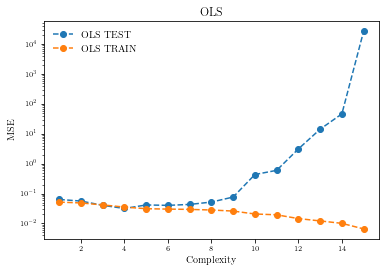

In [3]:
degree_values = np.arange(1,max_degree+1)
plt.semilogy(degree_values, mse_ols_test, "o--", label = "OLS TEST")
plt.semilogy(degree_values, mse_ols_train, "o--", label = "OLS TRAIN")
plt.title("OLS")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.legend(frameon=False)

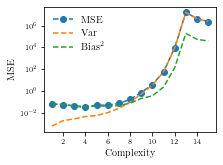

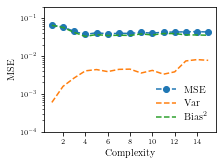

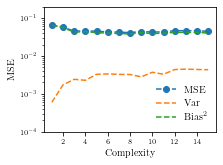

In [4]:
## BOOTSTRAP PLOTS
plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, ols_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ols_boot_variance,"--", label="Var")
plt.semilogy(degree_values, ols_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.tight_layout()
#plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degree_values, ridge_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 2e-1])
plt.tight_layout()
plt.legend(frameon=False)

plt.figure(figsize=FIGURESIZE * 0.8)
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_variance,"--", label="Var")
plt.semilogy(degree_values, lasso_best_lambda_boot_bias,"--", label="Bias$^2$")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 2e-1])
plt.legend(frameon=False)
plt.tight_layout()

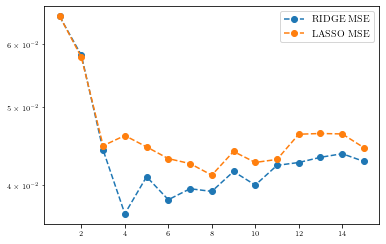

In [5]:
#plt.semilogy(degree_values, ols_boot_mse,"o--",label="OLS MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="RIDGE MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="LASSO MSE")
plt.legend()

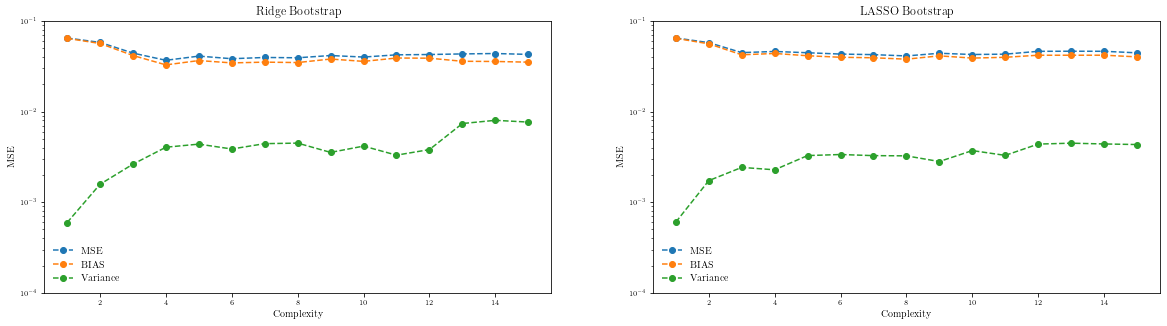

In [6]:
# Same bootstrap plots, but only better resolved LASSO & Ridge
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.semilogy(degree_values, ridge_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, ridge_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degree_values, ridge_best_lambda_boot_variance,"o--", label="Variance")
plt.title("Ridge Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)

plt.subplot(122)
plt.semilogy(degree_values, lasso_best_lambda_boot_mse,"o--",label="MSE")
plt.semilogy(degree_values, lasso_best_lambda_boot_bias,"o--", label="BIAS")
plt.semilogy(degree_values, lasso_best_lambda_boot_variance,"o--", label="Variance")
plt.title("LASSO Bootstrap")
plt.xlabel("Complexity")
plt.ylabel("MSE")
plt.ylim([1e-4, 1e-1])
plt.legend(frameon=False)
plt.show()

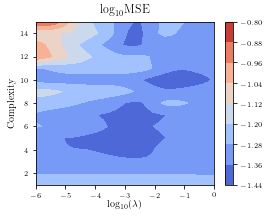

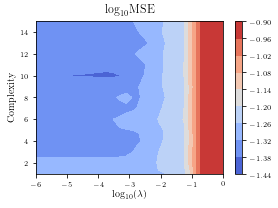

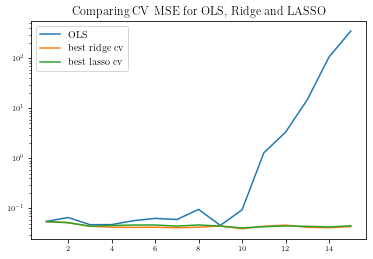

In [7]:
# CONTOUR PLOTS

# RIDGE
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degree_values)
plt.contourf(X, Y, np.log10(ridge_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")


# LASSO
plt.figure(figsize=(4, 3))
X, Y = np.meshgrid(np.log10(lambdas), degree_values)
plt.contourf(X, Y, np.log10(lasso_lamb_deg_mse), cmap=cm.coolwarm)
plt.colorbar()
plt.xlabel("$\\log_{10}(\lambda)$")
plt.ylabel("Complexity")
plt.title("$\log_{10}$MSE")
plt.tight_layout()

# CV MSE for OLS, Ridge and LASSO:
plt.figure()
plt.semilogy(degree_values, ols_cv_mse, label ='OLS')
plt.semilogy(degree_values, best_ridge_mse, label="best ridge cv")
plt.semilogy(degree_values, best_lasso_mse, label="best lasso cv")
plt.legend()
plt.title('Comparing CV MSE for OLS, Ridge and LASSO')
plt.show()

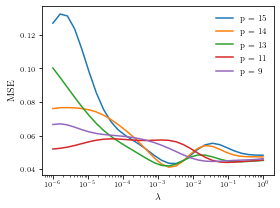

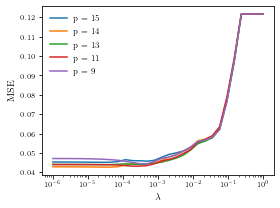

In [8]:
plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    ridge_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)
plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')


# For a copule of degrees, plot cv mse vs lambda for lasso, will break program if max_degree < 8.

plt.figure(figsize=FIGURESIZE)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 1],
    label="p = {}".format(max_degree),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 2],
    label="p = {}".format(max_degree - 1),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 3],
    label="p = {}".format(max_degree - 2),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 5],
    label="p = {}".format(max_degree - 4),
)
plt.semilogx(
    lambdas,
    lasso_lamb_deg_mse[max_degree - 7],
    label="p = {}".format(max_degree - 6),
)

plt.xlabel("$\\lambda$")
plt.ylabel("MSE")
plt.tight_layout()
plt.legend(frameon=False, fontsize="small", loc='best')

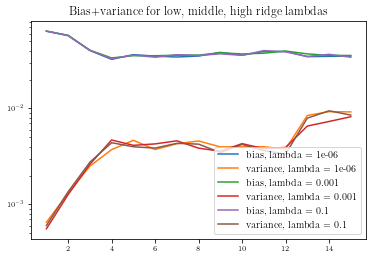

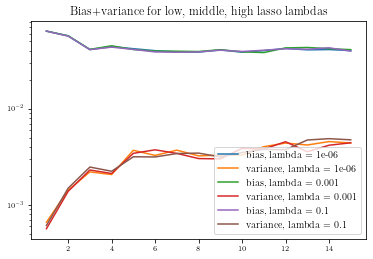

In [10]:
plt.figure()
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 0], label="bias, lambda = {}".format(subset_lambdas[0]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 0],
    label="variance, lambda = {}".format(subset_lambdas[0]),
)
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 3], label="bias, lambda = {}".format(subset_lambdas[3]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 3],
    label="variance, lambda = {}".format(subset_lambdas[3]),
)
plt.semilogy(degree_values, ridge_subset_lambda_boot_bias[:, 5], label="bias, lambda = {}".format(subset_lambdas[5]))
plt.semilogy(degree_values,
    ridge_subset_lambda_boot_variance[:, 5],
    label="variance, lambda = {}".format(subset_lambdas[5]),
)
plt.title("Bias+variance for low, middle, high ridge lambdas")
plt.legend()
plt.show()

plt.figure()
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 0], label="bias, lambda = {}".format(subset_lambdas[0]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 0],
    label="variance, lambda = {}".format(subset_lambdas[0]),
)
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 3], label="bias, lambda = {}".format(subset_lambdas[3]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 3],
    label="variance, lambda = {}".format(subset_lambdas[3]),
)
plt.semilogy(degree_values, lasso_subset_lambda_boot_bias[:, 5], label="bias, lambda = {}".format(subset_lambdas[5]))
plt.semilogy(degree_values,
    lasso_subset_lambda_boot_variance[:, 5],
    label="variance, lambda = {}".format(subset_lambdas[5]),
)
plt.title("Bias+variance for low, middle, high lasso lambdas")
plt.legend()
plt.show()

In [11]:
print(best_ridge_lambda)
print(best_lasso_lambda)

[1.00000000e+00 1.00000000e+00 1.37382380e-02 2.04335972e-03
 1.88739182e-04 1.26896100e-03 2.04335972e-03 2.04335972e-03
 3.56224789e-02 2.21221629e-02 9.23670857e-02 9.23670857e-02
 2.04335972e-03 2.04335972e-03 3.29034456e-03]
[1.26896100e-03 7.88046282e-04 1.17210230e-04 7.88046282e-04
 2.80721620e-05 7.27895384e-05 1.88739182e-04 1.88739182e-04
 4.89390092e-04 1.88739182e-04 1.88739182e-04 4.52035366e-05
 2.80721620e-05 2.80721620e-05 2.80721620e-05]


In [16]:
n=200 #Try, corresponding to above, 200 and 1000
noise_scale=0.2 #Try, corresponding to above, 0.0 and 0.2
degree=5 # See how the best hyperparameters from CV-MSE above actually perform.
ridge_lambda=1e-2 # Ditto
lasso_lambda=1e-4 # Ditto
plot_grid_size=2000

np.random.seed(2018)
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
z = FrankeFunction(x, y)
# Adding standard normal noise:
z = z + noise_scale * np.random.normal(0, 1, len(z))
#   Centering the response
z_intercept = np.mean(z)
z = z - z_intercept
# Scaling
X = linear_regression.design_matrix_2D(x, y, degree)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled = X_scaled[:,1:]

# Setting up plotting grid
x_plot = np.linspace(0, 1, plot_grid_size)
y_plot = np.linspace(0, 1, plot_grid_size)
x_plot_mesh, y_plot_mesh = np.meshgrid(x_plot, y_plot)
x_plot_mesh_flat, y_plot_mesh_flat = x_plot_mesh.flatten(), y_plot_mesh.flatten()

X_plot_design = linear_regression.design_matrix_2D(x_plot_mesh_flat, y_plot_mesh_flat, degree)
X_plot_design_scaled = scaler.transform(X_plot_design)
X_plot_design_scaled = X_plot_design_scaled[:,1:]

z_plot_franke = FrankeFunction(x_plot_mesh, y_plot_mesh)

# OLS
betas = linear_regression.OLS_SVD_2D(X_scaled, z)
z_predict_flat_ols = (X_plot_design_scaled @ betas) + z_intercept
z_predict_ols = z_predict_flat_ols.reshape(plot_grid_size, -1)

# Ridge

betas_ridge = linear_regression.Ridge_2D(X_scaled, z, ridge_lambda)
z_predict_flat_ridge = (X_plot_design_scaled @ betas_ridge) + z_intercept
z_predict_ridge = z_predict_flat_ridge.reshape(plot_grid_size, -1)
# Lasso

clf_Lasso = skl.Lasso(alpha=lasso_lambda, fit_intercept=False, max_iter=10000).fit(X_scaled, z)
z_predict_flat_lasso = clf_Lasso.predict(X_plot_design_scaled) + z_intercept
z_predict_lasso = z_predict_flat_lasso.reshape(plot_grid_size, -1)


/Users/thoreem/opt/anaconda3/envs/mlhome/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5674834015506418, tolerance: 0.002432716611271192
  positive)


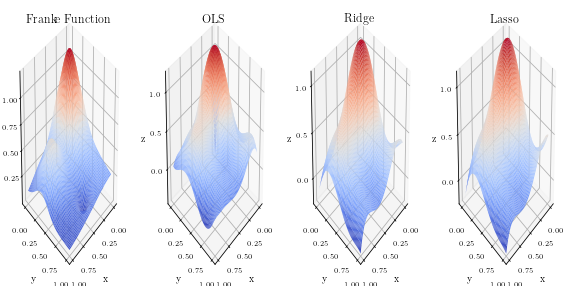

In [17]:
fig = plt.figure(figsize=(10,5))

# Plot the analytic curve
ax = fig.add_subplot(1, 4, 1, projection="3d")
ax.set_title("Franke Function")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_plot_franke, cmap=cm.coolwarm)

# Plot the OLS prediction
ax = fig.add_subplot(1, 4, 2, projection="3d")
ax.set_title("OLS")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ols, cmap=cm.coolwarm)
# Plot the Ridge
ax = fig.add_subplot(1, 4, 3, projection="3d")
ax.set_title("Ridge")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_ridge, cmap=cm.coolwarm)
# Plot the Lasso
ax = fig.add_subplot(1, 4, 4, projection="3d")
ax.set_title("Lasso")
ax.view_init(azim=45)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
surf = ax.plot_surface(x_plot_mesh, y_plot_mesh, z_predict_lasso, cmap=cm.coolwarm)
